**Name:** \_\_\_\_\_Huanchen Wang\_\_\_\_\_

**EID:** \_\_\_\_\_huancwang2\_\_\_\_\_

# CS5489 - Tutorial 10
## Using Deep Features

In this tutorial you will train a classifier to classify images with different types of cakes using deep features.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
import skimage.io
import skimage.transform

Second, initialize Keras and Tensorflow

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, Input, BatchNormalization, \
                                    GlobalAveragePooling2D, Concatenate, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import tensorflow.keras.applications.resnet50 as resnet
import logging
logging.basicConfig()
import struct
import sys
print("Python:", sys.version, "Keras:", keras.__version__, "TF:", tf.__version__)
# use keras backend (K) to force channels-last ordering
K.set_image_data_format('channels_last')

Python: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)] Keras: 2.11.0 TF: 2.11.0


## Loading Data and Pre-processing
Next we need to load the images.  Download `cakes.zip`, and put it in the same direcotry as this ipynb file.  **Do not unzip the file.** Then run the following cell to load the images.

In [3]:
imgdata = []
classes = []

# load the zip file
filename = 'cakes.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "cakes/*/*.jpg"):
        
        # filename is : cakes/class/file.jpg
        (fdir1, fname)  = os.path.split(name)  # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class 

        # open file in memory, and parse as an image
        myfile = zfile.open(name)
        #img = matplotlib.image.imread(myfile)
        img = skimage.io.imread(myfile)
        img2 = skimage.transform.resize(img, (224,224), anti_aliasing=False)
        
        myfile.close()

        imgdata.append(img2)
        classes.append(fclass)
        
zfile.close()
print(len(imgdata))
print(img.size)

c:\cityu_life\Anaconda\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


800
589824


In [4]:
def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if 'accuracy' in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history['accuracy'], 'b', label="training acc ({:.4f})".format(history.history['accuracy'][-1]))
        ax2.plot(history.history['val_accuracy'], 'b--', label="validation acc ({:.4f})".format(history.history['val_accuracy'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

Each image is a 224x224. There are 8 classes of differerent cakes.  Run the below code to show examples of each class.

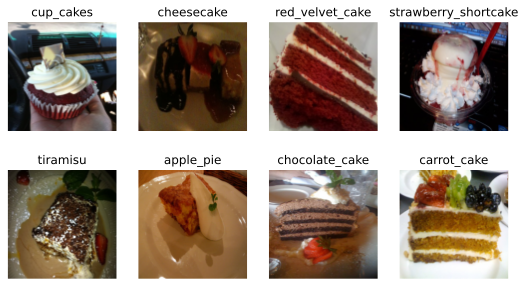

In [5]:
plt.figure(figsize=(9,5))
for i in range(8):
    plt.subplot(2,4,i+1)
    ind = i*100
    plt.imshow(imgdata[ind])    
    plt.title(classes[ind])
    plt.axis('off')
plt.show()

Next, store the images into a Tensor. ResNet assumes the data is [0,255] range, so we need to scale the images that were read in with skimage.

In [37]:
Xraw = zeros((len(imgdata), 224, 224, 3))
for i,img in enumerate(imgdata):
    x = image.img_to_array(img)*255   # preprocessing expects range [0,255]
    x = expand_dims(x, axis=0)
    Xraw[i,:] = x

Finally, we convert the class label strings into class numbers.

In [22]:
# convert class strings into integers
print("class labels (strings):", unique(classes))
le = preprocessing.LabelEncoder()
Y = le.fit_transform(classes)
print("Converted labels:")
print(Y)
Yb = keras.utils.to_categorical(Y)

class labels (strings): ['apple_pie' 'carrot_cake' 'cheesecake' 'chocolate_cake' 'cup_cakes'
 'red_velvet_cake' 'strawberry_shortcake' 'tiramisu']
Converted labels:
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7
 7 7 7 7 7

## Extract Deep features
Now preprocess the images in imdata and put them into a 4D tensor for ResNet.  Store it in a tensor `Xim`.  
Note that `preprocess_input` will overwrite its input data, so you may need to make a `copy` if you want to preserve `Xraw`.

In [ ]:
### INSERT YOUR CODE HERE ###

In [8]:
Xraw.shape

(800, 224, 224, 3)

In [8]:


Xim = zeros((len(imgdata), 224, 224, 3))

for i in range(len(imgdata)):
    xi = Xraw[i,:,:,:]
    xi = resnet.preprocess_input(xi)
    Xim[i,:] = xi
print(Xim.shape)


(800, 224, 224, 3)


Extract features from Resnet50, call it `Xf`.

In [ ]:
### INSERT YOUR CODE HERE ###

In [9]:
model_final = resnet.ResNet50(weights='imagenet', include_top=False, pooling='avg')

Xf = model_final.predict(Xim)
print(Xf.shape)

25/25 [==============================] - 30s 1s/step
(800, 2048)


##  Train a classifier
Split the data into training and testing for the classifier.

In [10]:
# randomly split data into train and test set
( trainXf, testXf,       # features 
  trainY, testY,         # class labels
  trainYb, testYb,       # class one-hot vectors
  trainXim, testXim,     # processed images
  trainimgdata, testimgdata,     # raw images
) = \
  model_selection.train_test_split(Xf, Y, Yb, Xim, imgdata,
  train_size=0.8, test_size=0.2, random_state=4487)

print(trainXf.shape)
print(testXf.shape)

# cleanup memory
del trainimgdata, Xraw

(640, 2048)
(160, 2048)


Now train a few traditional classifier (e.g, SVM, logistic regression, random forest, etc.) and compute the accuracy.

In [ ]:
### INSERT YOUR CODE HERE ###

In [19]:
paramgrid = {'C': logspace(-3,3,13)}

svmcv = model_selection.GridSearchCV(svm.SVC(kernel='linear',random_state=4646), paramgrid, cv=5,
n_jobs=-1, verbose=True)

svmcv.fit(trainXf, trainY)

print("Best parameters:", svmcv.best_params_)
print("Best score:", svmcv.best_score_)
print("Test score:", svmcv.score(testXf, testY))


Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best parameters: {'C': 0.0031622776601683794}
Best score: 0.628125
Test score: 0.6625


In [23]:
paramgrid = {'C': logspace(-3,3,13)}

lrcv = model_selection.GridSearchCV(linear_model.LogisticRegression(random_state=4646), paramgrid, cv=5, 
n_jobs=-1, verbose=True)

lrcv.fit(trainXf, trainY)

print("Best parameters:", lrcv.best_params_)
print("Best score:", lrcv.best_score_)
print("Test score:", lrcv.score(testXf, testY))


Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best parameters: {'C': 0.001}
Best score: 0.6234375
Test score: 0.70625


In [24]:
# random forest
paramgrid = {'n_estimators': [10, 50, 100, 200], 'max_depth': [2, 4, 8, 16]}

rfcv = model_selection.GridSearchCV(ensemble.RandomForestClassifier(random_state=4646), paramgrid, cv=5,
n_jobs=-1, verbose=True)

rfcv.fit(trainXf, trainY)

print("Best parameters:", rfcv.best_params_)
print("Best score:", rfcv.best_score_)
print("Test score:", rfcv.score(testXf, testY))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'max_depth': 8, 'n_estimators': 200}
Best score: 0.6
Test score: 0.60625


In [25]:
mypred = rfcv.predict(testXf)

Accuracy: 0.60625


## Analyze results

Run the below code to visualize the predictions on the test set.  `mypred` are the class predictions from your classifier.

In [26]:
# get the class labels
predYcl = le.inverse_transform(mypred)
testYcl = le.inverse_transform(testY)

plt.figure(figsize=(10,50))
px = 8
py = int(ceil(len(predYcl)/5))
for i in range(len(predYcl)):
    plt.subplot(py,px,i+1)
    mytitle = predYcl[i] + "\n(" + testYcl[i] + ")" 
    plt.imshow(testimgdata[i], interpolation='nearest')
    plt.title(mytitle, size=8)
    plt.gca().set_axis_off()

Now look at the confusion matrix

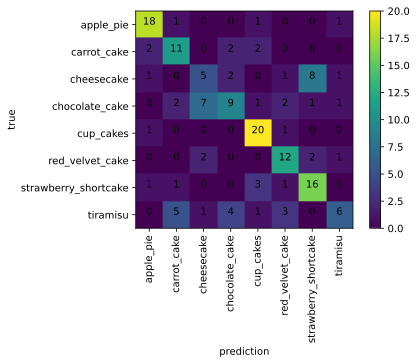

In [27]:
CM = metrics.confusion_matrix(testY, mypred)

plt.imshow(CM, interpolation='nearest')
plt.colorbar()

tick_marks = arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=90)
plt.yticks(tick_marks, le.classes_)
plt.xlabel('prediction')
plt.ylabel('true')
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        plt.text(j,i,"{}".format(CM[i,j]), horizontalalignment='center')

_How does the classifier make errors?_
- **INSERT YOUR ANSWER HERE**

- The above confusion matrix is based on the prediction of the random forest classifier
- The classifier's prediction accuracy is around 0.70
- The label 'cup_cakes' have most correct predictions, get 20 correct predictions.
- The classifier makes more error on 'cheesecake', and 'tiramisu'.
- To the cheesecake, it misclassified as 'strawberry_shortcake' most of the time. It really need detailed features and has diffuclty to distinguishing the cheesecake and the strawberry_shortcake.

# Transfer learning

Try using a pre-trained network as the backbone for a new network. You can try some of the following:
- training an MLP classifier using the 2048 features from ResNet.
- using other networks (e.g., InceptionNet) to extract the features.
  - remember to change the pre-processing step too.
- using the a feature map (7x7x2048) and applying a small CNN.
- fine-tuning the whole network.

In [ ]:
### INSERT YOUR CODE HERE ####

# Using the MLP classifier

In [23]:
K.clear_session()
random.seed(4487); tf.random.set_seed(4487)
base_model = resnet.ResNet50(weights='imagenet', include_top=False, pooling='avg')

x = base_model.output

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(unique(classes)), activation='softmax')(x)

In [24]:
model_ft = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model_ft.compile(optimizer='rmsprop',
loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
vtrainXim, validXim, vtrainYb, validYb = \
model_selection.train_test_split(trainXim, trainYb,
train_size=0.9, test_size=0.1, random_state=6487)
# validation data
validset = (validXim, validYb)

In [26]:
def add_gauss_noise(X, sigma2=0.1): #0.05
# add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)
# build the data augmenter
datagen = ImageDataGenerator(
rotation_range=10, # image rotation
width_shift_range=0.1, # image shifting
height_shift_range=0.1, # image shifting
shear_range=0.1, # shear transformation
zoom_range=0.1, # zooming
horizontal_flip=True,
preprocessing_function=add_gauss_noise,
)
# fit (required for some normalization augmentations)
datagen.fit(vtrainXim)

In [27]:
batch_size =32
callback_list = []
history = model_ft.fit(datagen.flow(vtrainXim, vtrainYb, batch_size=batch_size), steps_per_epoch=len(vtrainXim) / batch_size, epochs=20, validation_data=validset, callbacks=callback_list)

Epoch 1/20
18/18 [==============================] - 105s 6s/step - loss: 2.2039 - accuracy: 0.1372 - val_loss: 1.9690 - val_accuracy: 0.2500
Epoch 2/20
18/18 [==============================] - 96s 5s/step - loss: 1.9759 - accuracy: 0.2153 - val_loss: 1.7965 - val_accuracy: 0.3125
Epoch 3/20
18/18 [==============================] - 103s 6s/step - loss: 1.9008 - accuracy: 0.2604 - val_loss: 1.6885 - val_accuracy: 0.4219
Epoch 4/20
18/18 [==============================] - 98s 5s/step - loss: 1.7515 - accuracy: 0.2969 - val_loss: 1.7387 - val_accuracy: 0.3906
Epoch 5/20
18/18 [==============================] - 95s 5s/step - loss: 1.6990 - accuracy: 0.3264 - val_loss: 1.6567 - val_accuracy: 0.4062
Epoch 6/20
18/18 [==============================] - 94s 5s/step - loss: 1.5758 - accuracy: 0.4392 - val_loss: 1.4917 - val_accuracy: 0.4219
Epoch 7/20
18/18 [==============================] - 93s 5s/step - loss: 1.4897 - accuracy: 0.4618 - val_loss: 1.3763 - val_accuracy: 0.5000
Epoch 8/20
18/18 [

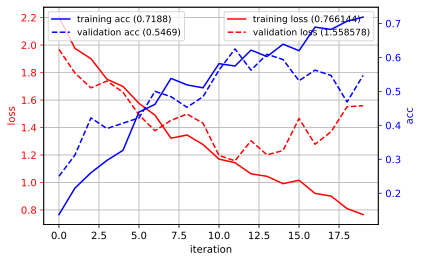

In [32]:
plot_history(history)

In [31]:
predY = argmax(model_ft.predict(testXim, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

test accuracy: 0.625


# Using other network to extract features

In [38]:
# preprcess the images

import tensorflow.keras.applications.inception_v3 as inception_v3

Xim_new = zeros((len(imgdata), 224, 224, 3))

for i in range(len(imgdata)):
    xi = Xraw[i,:,:,:]
    xi = inception_v3.preprocess_input(xi)
    Xim_new[i,:] = xi
print(Xim_new.shape)

(800, 224, 224, 3)


In [39]:
(trainY, testY,         # class labels
  trainYb, testYb,       # class one-hot vectors
  trainXim_new, testXim_new,     # processed images
  trainimgdata, testimgdata,     # raw images
) = \
  model_selection.train_test_split(Y, Yb, Xim_new, imgdata,
  train_size=0.8, test_size=0.2, random_state=4487)

# split into training and validation sets
vtrainXim_new, validXim_new, vtrainYb, validYb = \
model_selection.train_test_split(trainXim_new, trainYb,
train_size=0.9, test_size=0.1, random_state=6487)

In [40]:
validset_new = (validXim_new, validYb)

In [41]:
K.clear_session()
random.seed(4487); tf.random.set_seed(4487)
base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling='avg')

x = base_model.output

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(unique(classes)), activation='softmax')(x)

In [42]:
model_ft = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model_ft.compile(optimizer='adam', 
loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
def add_gauss_noise(X, sigma2=0.1): #0.05
# add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)
# build the data augmenter
datagen = ImageDataGenerator(
rotation_range=10, # image rotation
width_shift_range=0.1, # image shifting
height_shift_range=0.1, # image shifting
shear_range=0.1, # shear transformation
zoom_range=0.1, # zooming
horizontal_flip=True,
preprocessing_function=add_gauss_noise,
)
# fit (required for some normalization augmentations)
datagen.fit(vtrainXim_new)

In [44]:
batch_size =32
callback_list = []
history = model_ft.fit(datagen.flow(vtrainXim_new, vtrainYb, batch_size=batch_size), steps_per_epoch=len(vtrainXim_new) / batch_size, epochs=20, validation_data=validset_new, callbacks=callback_list)

Epoch 1/20
18/18 [==============================] - 82s 4s/step - loss: 2.3028 - accuracy: 0.1493 - val_loss: 2.0290 - val_accuracy: 0.3281
Epoch 2/20
18/18 [==============================] - 75s 4s/step - loss: 2.0843 - accuracy: 0.1545 - val_loss: 1.9575 - val_accuracy: 0.2656
Epoch 3/20
18/18 [==============================] - 79s 4s/step - loss: 1.9716 - accuracy: 0.2188 - val_loss: 1.8899 - val_accuracy: 0.3750
Epoch 4/20
18/18 [==============================] - 80s 4s/step - loss: 1.8809 - accuracy: 0.2656 - val_loss: 1.7865 - val_accuracy: 0.3125
Epoch 5/20
18/18 [==============================] - 78s 4s/step - loss: 1.8119 - accuracy: 0.2951 - val_loss: 1.7280 - val_accuracy: 0.4219
Epoch 6/20
18/18 [==============================] - 77s 4s/step - loss: 1.7915 - accuracy: 0.3229 - val_loss: 1.6798 - val_accuracy: 0.2812
Epoch 7/20
18/18 [==============================] - 76s 4s/step - loss: 1.7030 - accuracy: 0.3628 - val_loss: 1.6430 - val_accuracy: 0.4531
Epoch 8/20
18/18 [==

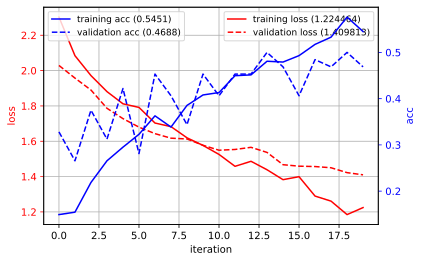

In [45]:
plot_history(history)

In [46]:
preY_new = argmax(model_ft.predict(testXim_new, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, preY_new)
print("test accuracy:", acc)

test accuracy: 0.54375


## Using a feature map ($7\times 7\times 2048$) and applying a small CNN

In [ ]:
### INSERT YOUR CODE HERE ###

In [41]:
model_ft = resnet.ResNet50(weights='imagenet', include_top=False)

Xf_new = model_ft.predict(Xim, verbose=False)

print(Xf_new.shape)

(800, 7, 7, 2048)


In [42]:
( trainXf_new, testXf_new,
  trainY_new, testY_new,        
  trainYb_new, testYb_new,       
) = \
  model_selection.train_test_split(Xf_new,Y,Yb,
  train_size=0.8, test_size=0.2, random_state=4487)

print(trainXf_new.shape)
print(testXf_new.shape)

vtrainf, validf, vtrainYb, validYb = \
model_selection.train_test_split(trainXf_new, trainYb_new,
train_size=0.8, test_size=0.2, random_state=6487)

validset_new = (validf, validYb)

(640, 7, 7, 2048)
(160, 7, 7, 2048)


In [67]:
# Using CNN to trian the feature map and prevent overfitting
import tensorflow.keras.callbacks as callbacks
K.clear_session()
random.seed(4487); tf.random.set_seed(4487)
nn = Sequential()


nn.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(7,7,2048)))
# nn.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
nn.add(BatchNormalization())
nn.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
# nn.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
nn.add(BatchNormalization())
nn.add(Dropout(0.5))
nn.add(Flatten())

nn.add(Dense(64, activation='relu'))
nn.add(Dense(32, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(len(unique(classes)), activation='softmax'))

earlystop = keras.callbacks.EarlyStopping(
                monitor='val_loss',             # use validation accuracy for stopping
                min_delta=0.0001, patience=5,
                verbose=-1, mode='auto')
callbacks_list = [earlystop]
nn.compile(loss=keras.losses.categorical_crossentropy,
                     optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                        metrics=['accuracy'])
batch_size = 32
history = nn.fit(vtrainf, vtrainYb, batch_size=batch_size, epochs=20, validation_data=validset_new, callbacks=callback_list)



Epoch 1/20
16/16 [==============================] - 3s 76ms/step - loss: 2.6364 - accuracy: 0.1504 - val_loss: 2.5941 - val_accuracy: 0.1562
Epoch 2/20
16/16 [==============================] - 1s 65ms/step - loss: 2.0143 - accuracy: 0.2383 - val_loss: 2.0955 - val_accuracy: 0.2188
Epoch 3/20
16/16 [==============================] - 1s 64ms/step - loss: 1.8533 - accuracy: 0.2969 - val_loss: 1.9941 - val_accuracy: 0.2891
Epoch 4/20
16/16 [==============================] - 1s 67ms/step - loss: 1.7070 - accuracy: 0.3613 - val_loss: 1.8102 - val_accuracy: 0.3516
Epoch 5/20
16/16 [==============================] - 1s 64ms/step - loss: 1.5203 - accuracy: 0.4180 - val_loss: 1.6502 - val_accuracy: 0.3828
Epoch 6/20
16/16 [==============================] - 1s 66ms/step - loss: 1.3914 - accuracy: 0.4844 - val_loss: 1.5695 - val_accuracy: 0.4297
Epoch 7/20
16/16 [==============================] - 1s 64ms/step - loss: 1.1351 - accuracy: 0.5879 - val_loss: 1.4778 - val_accuracy: 0.4688
Epoch 8/20
16

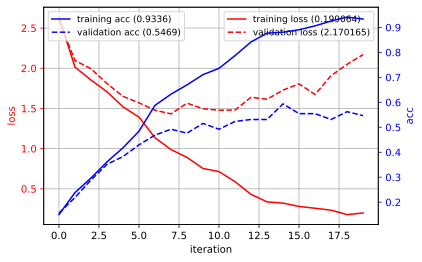

In [68]:
plot_history(history)

In [69]:
predY_new = argmax(nn.predict(testXf_new, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY_new, predY_new)
print("test accuracy:", acc)

test accuracy: 0.6125


## Fine tune the best performance whole network .

In [11]:
vtrainXim, validXim, vtrainYb, validYb = \
model_selection.train_test_split(trainXim, trainYb,
train_size=0.9, test_size=0.1, random_state=6487)
# validation data
validset = (validXim, validYb)

In [12]:
def add_gauss_noise(X, sigma2=0.1): #0.05
# add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)
# build the data augmenter

# datagen.fit(vtrainXim)

In [19]:
def model_archi(datagen, lr = 0.01):
    K.clear_session()
    random.seed(4487); tf.random.set_seed(4487)
    base_model = resnet.ResNet50(weights='imagenet', include_top=False, pooling='avg')

    x = base_model.output

    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(unique(classes)), activation='softmax')(x)

    model_ft = Model(inputs=base_model.input, outputs=predictions)

    # for layer in base_model.layers:
    #     layer.trainable = False

    model_ft.compile(loss=keras.losses.categorical_crossentropy,
                        optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True),
                            metrics=['accuracy'])


    batch_size = 32
    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=5,verbose=-1, mode='auto')
    callback_list = [earlystop]
    history = model_ft.fit(datagen.flow(vtrainXim, vtrainYb, batch_size=batch_size), steps_per_epoch=len(vtrainXim) / batch_size, epochs=20, validation_data=validset, callbacks=callback_list, verbose=0)

    return model_ft, history

In [14]:
def select_opt(opt_name, dataaug):
    model, his = model_archi(dataaug)
    predY = argmax(model.predict(testXim, verbose=False), axis=-1)
    acc = metrics.accuracy_score(testY, predY)
    print("test accuracy with {}={}: {}".format(opt_name,getattr(dataaug, opt_name),acc))
    return model, his, acc

In [15]:
opt_dict = {'ratation_range': [10, 30, 40], 'width_shift_range': [0.05, 0.15, 0.2], 'height_shift_range': [0.05, 0.15, 0.2], 
            'shear_range': [0.05, 0.15, 0.2], 'zoom_range': [[1-0.01, 1+0.01], [1-0.1,1+0.1], [1-0.2,1+0.2]], 'horizontal_flip': [True, False]}

best_acc = 0
best_model = None
best_his = None
for k, v in opt_dict.items():
    for i in v:
        dataaug = ImageDataGenerator(
            rotation_range=0,         # image rotation
            width_shift_range=0,     # image shifting
            height_shift_range=0,    # image shifting
            shear_range=0,           # shear transformation
            zoom_range=0,            # zooming
            horizontal_flip=False,       # horizontal flipping 
            preprocessing_function=add_gauss_noise,
            data_format='channels_last')
        setattr(dataaug, k, i)
        model,his, acc = select_opt(k, dataaug)
        if acc > best_acc:
            best_model = model
            best_his = his
            best_acc = acc


Epoch 1/20
18/18 [==============================] - 113s 6s/step - loss: 2.1135 - accuracy: 0.1649 - val_loss: 1.9341 - val_accuracy: 0.2031
Epoch 2/20
18/18 [==============================] - 118s 7s/step - loss: 1.7181 - accuracy: 0.3299 - val_loss: 2.4840 - val_accuracy: 0.1562
Epoch 3/20
18/18 [==============================] - 86s 5s/step - loss: 1.3449 - accuracy: 0.5226 - val_loss: 2.2502 - val_accuracy: 0.3125
Epoch 4/20
18/18 [==============================] - 76s 4s/step - loss: 1.0035 - accuracy: 0.6406 - val_loss: 2.4066 - val_accuracy: 0.4219
Epoch 5/20
18/18 [==============================] - 76s 4s/step - loss: 1.0263 - accuracy: 0.6562 - val_loss: 8.9650 - val_accuracy: 0.1875
Epoch 6/20
18/18 [==============================] - 76s 4s/step - loss: 0.8559 - accuracy: 0.7483 - val_loss: 2.3195 - val_accuracy: 0.2812
test accuracy with ratation_range=10: 0.33125
Epoch 1/20
18/18 [==============================] - 97s 5s/step - loss: 2.1055 - accuracy: 0.1562 - val_loss: 2.

### According to the result, set the best options for the ImageDataGenerator:
- rotation_range=40
- width_shift_range=0.2
- height_shift_range=0.05
- shear_range=0.2
- zoom_range=0.2
- horizontal_flip=True

In [20]:
def sel_lr(datagen, lr):
    model, his = model_archi(datagen,lr)
    predY = argmax(model.predict(testXim, verbose=False), axis=-1)
    acc = metrics.accuracy_score(testY, predY)
    print("test accuracy with lr={}: {}".format(lr,acc))
    return model, his, acc

In [21]:
lr_list = [0.01, 0.05, 0.1]
best_acc = 0
best_model = None
best_his = None
datagen = ImageDataGenerator(
    rotation_range=40,         # image rotation
    width_shift_range=0.2,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.2,           # shear transformation
    zoom_range=0.2,            # zooming
    horizontal_flip=True,       # horizontal flipping 
    preprocessing_function=add_gauss_noise,
    data_format='channels_last')
for lr in lr_list:
    model,his, acc = sel_lr(datagen, lr)
    if acc > best_acc:
        best_model = model
        best_his = his
        best_acc = acc

test accuracy with lr=0.01: 0.31875
test accuracy with lr=0.05: 0.1125
test accuracy with lr=0.1: 0.10625


## Analysis
For your best deep learning model, visualize the result and analyze the errors.

In [33]:
mypred = predY

In [34]:
# get the class labels
predYcl = le.inverse_transform(mypred)
testYcl = le.inverse_transform(testY)

plt.figure(figsize=(10,50))
px = 8
py = int(ceil(len(predYcl)/5))
for i in range(len(predYcl)):
    plt.subplot(py,px,i+1)
    mytitle = predYcl[i] + "\n(" + testYcl[i] + ")" 
    plt.imshow(testimgdata[i], interpolation='nearest')
    plt.title(mytitle, size=8)
    plt.gca().set_axis_off()

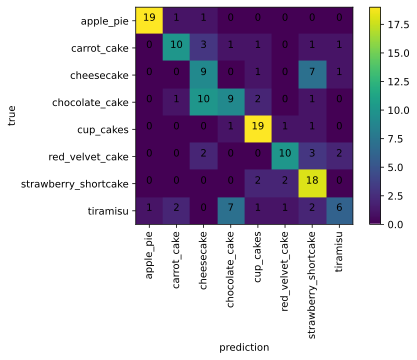

In [35]:
CM = metrics.confusion_matrix(testY, mypred)

plt.imshow(CM, interpolation='nearest')
plt.colorbar()

tick_marks = arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=90)
plt.yticks(tick_marks, le.classes_)
plt.xlabel('prediction')
plt.ylabel('true')
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        plt.text(j,i,"{}".format(CM[i,j]), horizontalalignment='center')

_Where you able to improve the accuracy using deep learning? Analyze the errors from your best model._
- **INSERT YOUR ANSWER HERE**

- The above confusion matrix is based on the prediction of ResNet50 + MLP classifier.
- To the methods can improve the accuracy, I tried to use the ResNet50 + MLP classifier, InceptionNet + MLP classifier, feature extraction from ResNet50 with shape ($7 \times 7\times 2048$) + CNN classifier, and fine tune the whole network.
  - To the ResNet50 + MLP classifier, the accuracy is 0.625.
  - To the InceptionNet + MLP classifier, the accuracy is 0.543.
  - To the feature extraction from ResNet50 with shape ($7 \times 7\times 2048$) + CNN classifier, the accuracy is 0.612.
  - To the fine tune the whole network, the accuracy is 0.318.
- Thus, I think the data augmentation and fine tune the parameters like learning rate can improve the accuracy.
- Based on my result, the feature extraction from ResNet50 with my MLP structure can get the better accuracy.

According to the result of the confusion matrix, the classifier makes correct prediction on the 'apple_pie', 'cup_cake', and 'strawberry_shortcake'. Whatsmore, it get lower error on the 'cheesecake' and 'tiramisu'. However, it still makes more error on the 'cheesecake' and 'tiramisu'. To the 'cheesecake', it misclassified as 'strawberry_shortcake' most of the time. To the 'tiramisu', it misclassified as 'chocolate_cakes' most of the time. It really need detailed features and has diffuclty to distinguishing the cheesecake and the strawberry_shortcake.
